# History Matching Convergence
Plot and examine rate of convergence for the history matching algorithm for different experiements, with varying number of samples per iteration $N$.

In [1]:
import config
import numpy as np
import joblib
import os 
from glob import glob
import matplotlib.pyplot as plt

CRITERION = 0.05 # If the NROY area changes by less than this fraction between iteration, consider the run converged. 
BASE_EXPERIMENTS = { ## UPDATE PATHS with experiment result paths
    '5': '/Users/robcking/PhD/history_matching_data/new/5_sample_exp',
    '10': '/Users/robcking/PhD/history_matching_data/new/10_sample_exp',
    '20': '/Users/robcking/PhD/history_matching_data/new/20_sample_exp',
    '50': '/Users/robcking/PhD/history_matching_data/new/50_sample_exp',
}

### NROY Space as a fn of $N$

In [2]:
def get_nroy_area_for_n(directory):
    spaces = [joblib.load(os.path.join(directory,f'{p}.space')) for p in range(len(glob(os.path.join(directory,f'*.space'))))]
    areas = []
    for s in spaces:
        sxr = s.to_xarray()
        dx = (sxr.cwtropics.max() - sxr.cwtropics.min())/sxr.cwtropics.size
        dy = (sxr.Bt_eq.max() - sxr.Bt_eq.min())/sxr.Bt_eq.size
        areas.append(100*float(dx*dy*sxr.sum())/(75*0.006))
    return np.array(areas)

def get_convergence_idx(areas,threshold):
    return np.argmax(((areas[:-1] - areas[1:])/areas[:-1]) < threshold) + 1




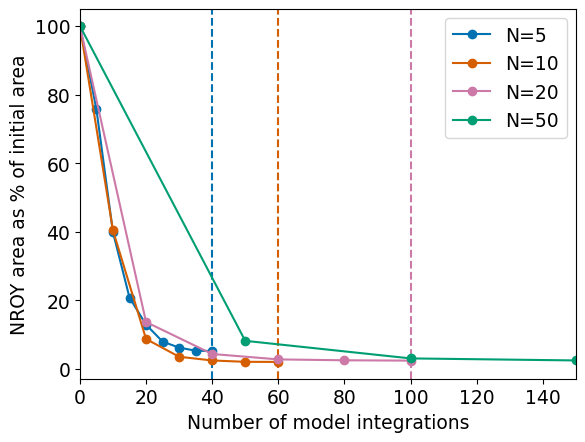

In [3]:
for k,v in BASE_EXPERIMENTS.items():
    areas = get_nroy_area_for_n(v)
    converged = get_convergence_idx(areas,CRITERION)
    x = np.arange(0,len(areas)*int(k),int(k))
    plt.plot(x[:converged+1],areas[:converged+1],color=config.COLORS[k],marker='o',label=f'N={k}')
    plt.axvline(x[converged],color=config.COLORS[k],linestyle='--')

plt.xlim(0,150)
plt.ylabel("NROY area as % of initial area")
plt.xlabel("Number of model integrations")
plt.legend()
plt.savefig("figures/conv_plot.png",dpi=200)


In [7]:
areas

array([100.        ,   8.20931334,   3.08386126,   2.48908895,
         2.1663526 ,   2.15031835,   2.09963587,   2.09205399,
         2.08769881,   2.08719422])

### Convergence Demonstration
Visualize the intermediate NROY spaces generated during the history matching procedure.

In [4]:
N=50 ## Users choice of N to visualize the NROY chain


In [5]:
from functools import reduce 
spaces = [joblib.load(os.path.join(BASE_EXPERIMENTS[str(N)],f'{p}.space')) for p in range(len(glob(os.path.join(BASE_EXPERIMENTS[str(N)],f'*.space'))))]
areas = get_nroy_area_for_n(BASE_EXPERIMENTS[str(N)])
conv = get_convergence_idx(areas,CRITERION)
convspaces = reduce(lambda x,y: x+y, [s.to_xarray().astype(int).interp(
    cwtropics=np.linspace(
        5,80,
        1000,
    ),
    Bt_eq=np.linspace(
        0.001,
        0.007,
        1000,
    ),
    kwargs={"fill_value": 0},
    ).astype(int) for s in  spaces[:conv]])

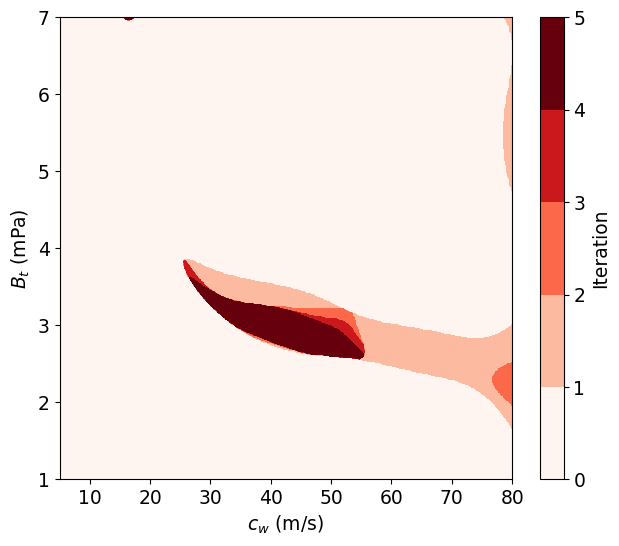

In [6]:
convspaces = convspaces.assign_coords(Bt_eq_mpa=("Bt_eq", convspaces.Bt_eq.values * 1000))
cbar = convspaces.plot.contourf(x='cwtropics',y='Bt_eq_mpa',cmap='Reds',levels=list(range(len(spaces[:conv]) + 1)),cbar_kwargs={'label':'Iteration'},figsize=(7.3,6))
plt.gca().set_xlabel('$c_w$ (m/s)')
plt.gca().set_ylabel("$B_t$ (mPa)")
plt.savefig(f'figures/{N}_hm_chain.png',dpi=200,bbox_inches='tight')


In [ ]:
s